<a href="https://colab.research.google.com/github/ArthurFDLR/pose-classification-kit/blob/master/examples/body_pose_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕺 Pose Classification Kit: Body pose classification model creation

This Notebook can be used to create Neural Network classifiers running in the [Pose Classification Kit](https://github.com/ArthurFDLR/pose-classification-kit).

First, we have to import several libraries to create and train a new model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.x
    !pip install pose-classification-kit
    
import tensorflow
from tensorflow import keras
from pose_classification_kit.datasets import BODY18, bodyDataset, dataAugmentation

print('Available GPU:')
!nvidia-smi -L
print('\nTensorFlow use GPU at: {}'.format(tensorflow.test.gpu_device_name()))

     |████████████████████████████████| 24.2 MB 23 kB/s 
Available GPU:
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


TensorFlow use GPU at: 


## Import dataset

In [2]:
dataset = bodyDataset(testSplit=.2, shuffle=True, bodyModel=BODY18)
x_train = dataset['x_train']
y_train = dataset['y_train_onehot']

x_train.shape, y_train.shape

((8040, 18, 2), (8040, 20))

## Data augmentation

In [3]:
x, y = [x_train], [y_train]

# Scaling augmentation
x[len(x):],y[len(y):] = tuple(zip(dataAugmentation(
    x_train, y_train,
    augmentation_ratio=.15,
    scaling_factor_standard_deviation=.08,
    random_noise_standard_deviation=.03,
)))

# Rotation augmentation
x[len(x):],y[len(y):] = tuple(zip(dataAugmentation(
    x_train, y_train,
    augmentation_ratio=.15,
    rotation_angle_standard_deviation=10,
    random_noise_standard_deviation=.03
)))

# Upper-body augmentation
lowerBody_keypoints = np.where(np.isin(BODY18.mapping,[
    "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"
]))[0]
x[len(x):],y[len(y):] = tuple(zip(dataAugmentation(
    x_train, y_train,
    augmentation_ratio=.4,
    remove_specific_keypoints=lowerBody_keypoints,
    random_noise_standard_deviation=.03
)))
                        
# Random partial input augmentation
x[len(x):],y[len(y):] = tuple(zip(dataAugmentation(
    x_train, y_train,
    augmentation_ratio=.2,
    remove_rand_keypoints_nbr=4,
    random_noise_standard_deviation=.03
)))

x_train_augmented = np.concatenate(x, axis=0)
y_train_augmented = np.concatenate(y, axis=0)

x_train_augmented.shape, y_train_augmented.shape

((15276, 18, 2), (15276, 20))

## Models exploration

This section is optional. The following blocks can be used to compare different architecture and training processes.

In [4]:
model_train_history = {}
input_dim = x_train.shape[1:]
output_dim = len(dataset['labels'])
validation_split = 0.20
epochs = 15

In [5]:
model = keras.models.Sequential(
    name = 'CNN',
    layers =
    [
        keras.layers.InputLayer(input_shape=input_dim),
        keras.layers.Conv1D(16, 3, activation='relu'),
        keras.layers.Dropout(0.25),
        keras.layers.Conv1D(32, 3, activation='relu'),
        keras.layers.Dropout(0.25),
        keras.layers.Conv1D(32, 3, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(32, activation=keras.activations.relu),
        keras.layers.Dense(output_dim, activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train_augmented,
    y=y_train_augmented,
    epochs=epochs,
    batch_size=32,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 16)            112       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 32)            1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 32)            3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0       

In [6]:
model = keras.models.Sequential(
    name = 'ANN',
    layers =
    [
        keras.layers.InputLayer(input_shape=input_dim),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(output_dim, activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train_augmented,
    y=y_train_augmented,
    epochs=epochs,
    batch_size=32,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
)

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2368      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0       

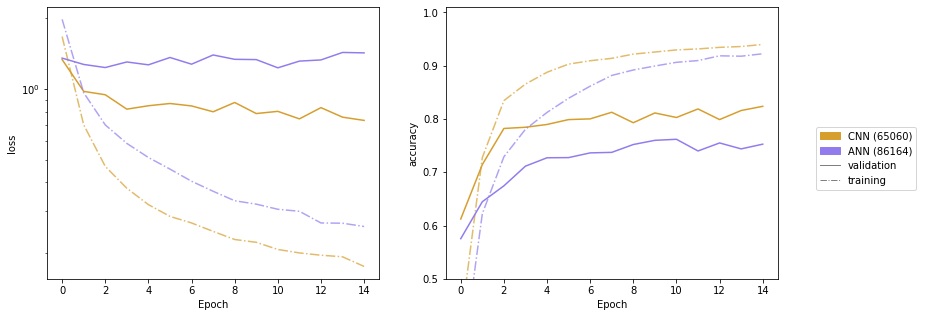

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
colors_graph = ["#d69e2d",
                "#927ced",
                "#73bd4d",
                "#e462c0",
                "#eb5e52"]
handles = []

for (model, history), color in zip(model_train_history.items(), colors_graph):
    label = '{} ({})'.format(model.name, model.count_params())
    axs[0].plot(history.history['loss'], c=color, ls='-.', alpha=.7)
    axs[1].plot(history.history['accuracy'], c=color, ls='-.', alpha=.7)
    axs[0].plot(history.history['val_loss'], c=color)
    axs[1].plot(history.history['val_accuracy'], c=color)
    handles.append(mpatches.Patch(color=color, label=label))

for ax in axs:
    ax.set_xlabel('Epoch')
axs[0].set_ylabel('loss')
axs[0].set_yscale('log')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0.5,1.01)

handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))

fig.subplots_adjust(right=0.85)
fig.legend(handles=handles,
           loc="center right",
           borderaxespad=1)

## Model export

Once you have a good model, you can save it on your Google Drive or local files. A model information JSON file is also added to store labels.

In [8]:
from pathlib import Path
import json

model_name = 'CNN_BODY18_1'

if IN_COLAB:
    content_path = Path('/').absolute() / 'content'
    drive_path = content_path / 'drive'
    google.colab.drive.mount(str(drive_path))
    save_path = drive_path / 'My Drive'
    
    for subfolder in ['Pose Classification Kit', 'Models', model_name]:
        save_path /= subfolder
        if not (save_path).is_dir():
            %mkdir "{save_path}"
else:
    save_path = Path('.').absolute() / model_name
    %mkdir "{save_path}"

model_path = save_path / '{name}.h5'.format(name = model_name)

Mounted at /content/drive


In [9]:
model = keras.models.Sequential(
    name = model_name,
    layers =
    [
        keras.layers.InputLayer(input_shape=input_dim),
        keras.layers.Conv1D(16, 3, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(32, 3, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(32, 3, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(32, activation=keras.activations.relu),
        keras.layers.Dense(output_dim, activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.fit(
    x=x_train_augmented,
    y=y_train_augmented,
    epochs=15,
    batch_size=4,
    validation_split=0.15,
    shuffle=True,
    callbacks=[keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=2, save_best_only=True)],
    verbose = 2,
)

with open(save_path / 'class.json', 'w') as f:
    json.dump({'labels':dataset['labels']}, f)

Model: "CNN_BODY18_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 16, 16)            112       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 32)            1568      
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 12, 32)            3104      
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 384)              

In [10]:
model = keras.models.load_model(model_path)
model.evaluate(x=dataset['x_test'], y=dataset['y_test_onehot'])

63/63 [==============================] - 0s 2ms/step - loss: 0.0542 - accuracy: 0.9880


[0.054189156740903854, 0.9879999756813049]